In [17]:
# These are global imports
%pylab inline
import sys
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.stats import rankdata
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import ndimage
import cPickle as pickle
from joblib import Parallel,delayed
# Connect to an R session
import nibabel as nb
import numpy.lib.recfunctions as nprf 

import seaborn as sns
from mvpa2.suite import *
from scipy.io import loadmat
from scipy.spatial.distance import squareform,pdist
from scipy.stats import rankdata,pearsonr
from scipy import stats

#import prettyplotlib as ppl
#import brewer2mpl
from mpl_toolkits.mplot3d import Axes3D
from nibabel.spatialimages import ImageFileError

Populating the interactive namespace from numpy and matplotlib


/data/nielsond/python/envs/py27mvpa/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'product', 'types', 'vstack', 'seed', 'random', 'ceil', 'hist', 'chisquare', 'save', 'test', 'matshow', 'hstack', 'lstsq', 'argsort', 'log10', 'info', 'floor']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Run ttest, make stat maps

In [2]:
#define paths and such

#define formula for glm, this is also a thing that may change run to run
fe_formula = 'val~ham+ham:viv_ave+viv_ave+correl+event'  # MODEL 1
run_name = 'perm_hamvivcorrel_stlim_SL4_zndist_1000perms_v1' #this one you should probably change for each run

spacemax = 10.**4.5
spacemin = 10.**2
#spacemin = 0
#timemin = 0
timemin = 10.**4.75
timemax =  10007180

method = 'glm'
run_type = '%s_sl'%(method)

basedir = '/data/nielsond/expSamp/data/'
data_dir = os.path.join(basedir,'input')
data_file = 'rsa_dataset_gps_time_old_exclude_drop_viv_bin_scan_time_rem_ham.pickle'  
outdir = '/data/nielsond/expSamp/data/output/%s_sl/%s'%(method,run_name)
ss_out_pat = 'betas.%s.%s.%s.%03d.nii.gz'
combined_out_pat = '%s.%s.%s.nii.gz'
fmri_pat = 'input/stb.%s_stb_qwarp_e2a.nii.gz'
subj_mask_pat = 'input/%s_mask_GM_full_+tlrc.nii.gz'
stat_out_pat = '%s.%s.%s.%s.%03d.nii.gz'

mask_pat='/data/nielsond/expSamp/data/input/MNI152_T1_2.5mm_GM_mask.nii.gz'
    

#conj_keys = ['ham','ham:viv_ave']#,'space','time'] #keys for conjunction analysis (what regions are sig for the conjunction)

subjects = ['expSamp01',
'expSamp02',
'expSamp03',
'expSamp04',
'expSamp05',
'expSamp07',
'expSamp08',
'expSamp09',
'expSamp10']


#make output directory if it doesn't exist
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
#load independent data
dat = np.load(os.path.join(data_dir,data_file))

In [3]:
outdir

'/data/nielsond/expSamp/data/output/glm_sl/perm_full_ks_stlim_SL4_zndist_1000perms_v1'

In [4]:
# Model 4
contrasts = {'event':1,'ham':2}
model_meas = {'deviance':(6),
             'scale':(7),
             'llf':(8),
             'count':(9)}


In [27]:
# Model 3
contrasts = {'correl':1,'event':2,'ham':3}
model_meas = {'deviance':(8),
             'scale':(9),
             'llf':(10),
             'count':(11)}


In [7]:
# Model 2
contrasts = {'event':1,'ham':2,'ham-viv_ave':3,'viv_ave':4}
model_meas = {'deviance':(10),
             'scale':(11),
             'llf':(12),
             'count':(13)}

In [162]:
contrasts = {'intercept':0,'correl':1,'event':2,'ham':3,'ham-viv_ave':4,
             'space':5, 'space:time':6,'time':7,'viv_ave':8}
model_meas = {'deviance':(18),
             'scale':(19),
             'llf':(20),
             'count':(21)}


In [3]:
contrasts = {'intercept':0,'correl':1,'event':2,'ham':3,'ham-viv_ave':4,'viv_ave':5}
model_meas = {'deviance':(12),
             'scale':(13),
             'llf':(14),
             'count':(15)}

#1 event betas
#2 ham betas
#3 space betas
#4 space:time betas
#5 time betas
#6 Intercept tvals
#7 event tvals
#8 ham tvals
#9 space tvals
#10 space:time tvals
#11 time tvals
#12 deviance
#13 scale
#14 llf
#15 count


In [5]:
#grab dat mask
mask = nb.load(mask_path) 
#stdmask = nb.load(std_mask_path)
ind = (mask.get_data()>0) #& (stdmask.get_data()>0))
count_thresh = 20

In [10]:
!ls /data/nielsond/expSamp/data/output/glm_sl/perm_full_ks_stlim_SL4_zndist_1000perms_v1/stats/*tfce.000*

/data/nielsond/expSamp/data/output/glm_sl/perm_full_ks_stlim_SL4_zndist_1000perms_v1/stats/correl.tvals_cmask.perm_full_ks_stlim_SL4_zndist_1000perms_v1.glm_sl.tfce.000.nii.gz
/data/nielsond/expSamp/data/output/glm_sl/perm_full_ks_stlim_SL4_zndist_1000perms_v1/stats/event.tvals_cmask.perm_full_ks_stlim_SL4_zndist_1000perms_v1.glm_sl.tfce.000.nii.gz
/data/nielsond/expSamp/data/output/glm_sl/perm_full_ks_stlim_SL4_zndist_1000perms_v1/stats/ham-viv_ave.tvals_cmask.perm_full_ks_stlim_SL4_zndist_1000perms_v1.glm_sl.tfce.000.nii.gz
/data/nielsond/expSamp/data/output/glm_sl/perm_full_ks_stlim_SL4_zndist_1000perms_v1/stats/ham.tvals_cmask.perm_full_ks_stlim_SL4_zndist_1000perms_v1.glm_sl.tfce.000.nii.gz
/data/nielsond/expSamp/data/output/glm_sl/perm_full_ks_stlim_SL4_zndist_1000perms_v1/stats/ham_cj_ham-viv_ave.tvals_cmask.perm_full_ks_stlim_SL4_zndist_1000perms_v1.glm_sl.cj_tfce.000.nii.gz
/data/nielsond/expSamp/data/output/glm_sl/perm_full_ks_stlim_SL4_zndist_1000perms_v1/stats/space.tvals_c

In [4]:
# get independent variables
#load independent data
dat = np.load(os.path.join(data_dir,data_file))

#swap strong and weak so that the main effects relflect pair strength strong
dat['pair_str'] = ['3weak' if dat['pair_str'][i] == '1weak' else '1strong' if dat['pair_str'][i]=='3strong' else dat['pair_str'][i] for i in range(len(dat))]

#Recode rem_ave such that rem_ave = 1 for rem_ave=0.5 or 1 (currently)
dat['rem_ave'] = [0 if dat['rem_ave'][i] == 0 else 1 for i in range(len(dat))]


#    #cheat and grab lah distance from old data
#   dat_old = np.load(os.path.join(data_dir,'rsa_dataset_gps_time_old_exclude_drop_viv_dif_lah.pickle'))
#    #data_file_old = 'rsa_dataset_gps_time_correl_all.pickle'
#    #dat_old = np.load(os.path.join(data_dir_old,data_file_old))

#    cd_new = []
#    for i in range(len(dat)):
#        ind = ((dat_old['subject'] == dat['subject'][i]) & ( dat_old['s1_trial'] == dat['s1_trial'][i]) & (dat_old['s2_trial'] == dat['s2_trial'][i]))
#        cd_new.append(dat_old['LAH_dist'][ind])
#        
#    dat = nprf.rec_append_fields(dat,'LAH_dist',np.array(cd_new).squeeze())

#cheat and grab correl distance from old data
#data_dir_old = os.path.join(basedir,'rsa/gps_time_correl_all')  # CHECK IF ALL 120 for all subs, then check if they are getting appended correctly
data_file_old = 'rsa_dataset_gps_time_correl_all.pickle'
dat_old = np.load(os.path.join(data_dir,data_file_old))

cd_new = []
for i in range(len(dat)):
    ind = ((dat_old['subject'] == dat['subject'][i]) & ( dat_old['s1_trial'] == dat['s1_trial'][i]) & (dat_old['s2_trial'] == dat['s2_trial'][i]))
    cd_new.append(dat_old['correl'][ind])

dat = nprf.rec_append_fields(dat,'correl',np.array(cd_new).squeeze())


#Drop 118 from expSamp07
sind = (dat['subject']=='expSamp07') & ((dat['s1_trial']==118) | (dat['s2_trial']==118))
for i in range(len(sind)):
    if sind[i]== True:
        dat[i]['pair_str']='0exclude'    # <codecell>
dat = dat[dat['pair_str']!='0exclude']

kept_stims = {}
for subj in subjects:
    s1_exclude = np.array(np.unique(dat[((dat['subject']==subj) & (dat['pair_str'] != '0exclude'))]['s1_trial']))
    s2_exclude = np.array(np.unique(dat[((dat['subject']==subj) & (dat['pair_str'] != '0exclude'))]['s2_trial']))
    kept_stims[subj] = np.unique(np.array([s1_exclude,s2_exclude]))-1

In [5]:
datdf = pd.DataFrame(dat)

In [6]:
cj_name = "ham_cj_ham-viv_ave.tvals_cmask.perm_hamvivcorrel_stlim_SL4_zndist_1000perms_v1.glm_sl.cj_tfce.000.nii.gz"
cj = nb.load(os.path.join(outdir,"stats",cj_name))
radius = 3

In [7]:
#get conjunciton data
cj_dat = cj.get_data()

In [8]:
# Get array indices corresponding to sphere centered at max value of conjunction
center_point = [i[0] for i in np.where(cj_dat == cj_dat.max())]
coords = np.array(Sphere(radius)(center_point)).squeeze()
cx = coords[:,0]
cy = coords[:,1]
cz = coords[:,2]

In [9]:
# Turn indicies into a mask
sl_mask = np.zeros(cj_dat.shape)
sl_mask[cx,cy,cz] = 1

In [10]:
center_point

[29, 23, 38]

# Add Neural distances to dataframe

In [11]:
# calculate neural distances
def get_neural_distance(d, index, mask,zdist = False, use_rank = False, metric = "correlation"):
    ndist = pdist(d[mask].T, metric=metric)[index]
    if zdist == True:
        ndist = (ndist-np.average(ndist))/np.std(ndist)
    if use_rank:
        #rank it
        ndist = rankdata(ndist)
    return ndist

In [12]:
with open('/data/nielsond/expSamp/data/input/ham_perms_all.npz','rb') as handle:
        perm_dict = pickle.load(handle)


In [13]:
res = {}
for subj in subjects:
    subj_mask =  nb.load(os.path.join(basedir,subj_mask_pat%(subj))).get_data()
    mask = subj_mask.astype(bool) & sl_mask.astype(bool)
    ds = nb.load(os.path.join(basedir,fmri_pat%(subj))).get_data()
    #dsmask = fmri_dataset(os.path.join(basedir,subj_mask_pat%(subj)),mask=mask_pat)

    # define index
    # ind = (((dat[dat['subject']==subj]['pair_str']=='1strong') | (dat[dat['subject']==subj]['pair_str']=='3weak')) &
    #ind = dat[dat['subject']==subj]['subject']==subj # USE THIS
    #ind=dat[dat['subject']==subj]['rem_ave']==1
    #ind=dat[dat['subject']==subj]['rem']==True | (dat[dat['subject']==subj]['rem']==False))
    #ind=((dat[dat['subject']==subj]['rem']==True) | (dat[dat['subject']==subj]['rem']==False))  
           #&
    #ind= ((dat[dat['subject']==subj]['rem_ave']==0) & (dat[dat['subject']==subj]['space'] < spacemax) & (dat[dat['subject'] == subj]['space'] > spacemin) &
    #      (dat[dat['subject']==subj]['time'] < timemax) & (dat[dat['subject'] == subj]['time'] > timemin))

    ind= ((dat[dat['subject']==subj]['space'] < spacemax) & (dat[dat['subject'] == subj]['space'] > spacemin) &
          (dat[dat['subject']==subj]['time'] < timemax) & (dat[dat['subject'] == subj]['time'] > timemin))
    res[subj] = get_neural_distance(ds[:,:,:,perm_dict[subj][0]],ind,mask,zdist = True)    



In [19]:
for subj in subjects:
    dfind = ((datdf.subject == subj) & (datdf.pair_str != '0exclude') 
    & (datdf.space<spacemax) & (datdf.space > spacemin)
    & (datdf.time<timemax) & (datdf.time > timemin))
    datdf.loc[dfind,'val'] = res[subj]
        

# Add betas to dataframe

In [182]:
n = 0
betas = []
for subj in subjects:
    betas.append(nb.load(os.path.join(outdir,ss_out_pat%(subj,run_name,run_type,n))).get_data()[center_point[0],center_point[1],center_point[2],:])

In [183]:
for k,v in contrasts.items():
    for i,subj in enumerate(subjects):
        datdf.loc[datdf.subject == subj,k+'_beta'] = betas[i][v]

In [196]:
for subj in subjects:
    dfind = ((datdf.subject == subj) & (datdf.pair_str != '0exclude') 
    & (datdf.space<spacemax) & (datdf.space > spacemin)
    & (datdf.time<timemax) & (datdf.time > timemin))
    break

In [23]:
datdf['space'] = np.log10(datdf.space)
datdf['time'] = np.log10(datdf.time)
datdf['event'] = np.log10(datdf.event)

/spin1/users/nielsond/python/envs/py27mvpa/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [15]:
from statsmodels.graphics.regressionplots import partial_resids


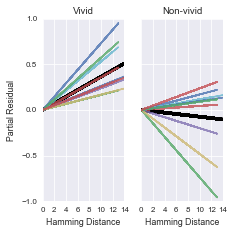

In [24]:
sns.set_context("paper")
fig,axs = subplots(1,2, sharey = True, figsize = (3.346,3.346))
ham_betas = []
ham_viv_ave_betas = []
for j,subj in enumerate(subjects):
    dfind = ((datdf.subject == subj)& (datdf.pair_str != '0exclude') 
    & (datdf.space<np.log10(spacemax)) & (datdf.space > np.log10(spacemin))
    & (datdf.time<np.log10(timemax)) & (datdf.time > np.log10(timemin)))
    modl= smf.glm(formula=fe_formula, data=datdf.loc[dfind,:])
    mdf = modl.fit()
    datdf.loc[dfind,'ham_ham:viv_resid'] = partial_resids(mdf,'ham') + partial_resids(mdf,'ham:viv_ave') - (mdf.model.endog-mdf.predict())
   
    for i in range(2):
        ax = axs[i]
        x = datdf.loc[dfind &(datdf.viv_ave == i),'ham']
        #x+= j*.1
        yr = datdf.loc[dfind &(datdf.viv_ave == i),'ham_ham:viv_resid']
        yb = (mdf.params['ham']) * x + (mdf.params['ham:viv_ave'] * i * x)
        #ax.plot(x,yr,'o', alpha = 0.1)
        ax.plot(x,yb, alpha = 0.8, zorder = 1000)
        if i == 0:
            ham_betas.append(mdf.params['ham'])
            ham_viv_ave_betas.append(mdf.params['ham:viv_ave'])
for i in range(2):

    ax = axs[i]
    dfind = ((datdf.pair_str != '0exclude') 
        & (datdf.space<np.log10(spacemax)) & (datdf.space > np.log10(spacemin))
        & (datdf.time<np.log10(timemax)) & (datdf.time > np.log10(timemin)))
    
    x = datdf.loc[dfind&(datdf.viv_ave == i),'ham']
    y = np.average(ham_betas) * x + (np.average(ham_viv_ave_betas) * i * x)
    ax.plot(x,y,lw = 3, color = 'black')
    ax.set_xlabel('Hamming Distance')

ax = axs[0]
ax.set_ylabel("Partial Residual")
ax.set_title('Vivid')
ax = axs[1]
ax.set_title('Non-vivid')
fig.tight_layout()
fig.savefig("ham_resid_plot.pdf")
fig.savefig("ham_resid_plot.svg")
fig.savefig("ham_resid_plot.png",dpi = 1000)

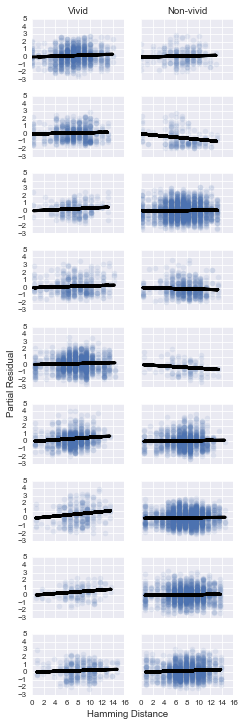

In [32]:
fig,axs = subplots(len(subjects),2, sharey = True, sharex = True, figsize = (3.346,10))
ham_betas = []
ham_viv_ave_betas = []
for j,subj in enumerate(subjects):
    dfind = ((datdf.subject == subj)& (datdf.pair_str != '0exclude') 
    & (datdf.space<np.log10(spacemax)) & (datdf.space > np.log10(spacemin))
    & (datdf.time<np.log10(timemax)) & (datdf.time > np.log10(timemin)))
    modl= smf.glm(formula=fe_formula, data=datdf.loc[dfind,:])
    mdf = modl.fit()
    datdf.loc[dfind,'ham_ham:viv_resid'] = partial_resids(mdf,'ham') + partial_resids(mdf,'ham:viv_ave') - (mdf.model.endog-mdf.predict())
   
    for i in range(2):
        ax = axs[j,i]
        x = datdf.loc[dfind &(datdf.viv_ave == i),'ham']
        x+= j*.1
        yr = datdf.loc[dfind &(datdf.viv_ave == i),'ham_ham:viv_resid']
        yb = (mdf.params['ham']) * x + (mdf.params['ham:viv_ave'] * i * x)
        ax.plot(x,yr,'o', alpha = 0.1)
        ax.plot(x,yb,lw = 3, color = 'black')
        if i == 0:
            ham_betas.append(mdf.params['ham'])
            ham_viv_ave_betas.append(mdf.params['ham:viv_ave'])
        

axs[0,0].set_title('Vivid')
axs[0,1].set_title('Non-vivid')
fig.text(0.5, 0, 'Hamming Distance', ha = 'center')
fig.text(0,0.5, 'Partial Residual',rotation = 'vertical')
fig.tight_layout()
fig.savefig("ham_resid_plot_subj.pdf")
fig.savefig("ham_resid_plot_subj.svg")
fig.savefig("ham_resid_plot_subj.png",dpi = 1000)

# Get atlas regions with sig voxels
## conjunction

In [49]:
from nilearn import datasets
import nilearn as nil

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', symmetric_split = True)


In [51]:
cj_name = "ham_cj_ham-viv_ave.tvals_cmask.perm_hamvivcorrel_stlim_SL4_zndist_1000perms_v1.glm_sl.cj_tfce.000.nii.gz"
cj = nb.load(os.path.join(outdir,"stats",cj_name))
resamp = nil.image.resample_to_img(dataset.maps,cj,interpolation = 'nearest')

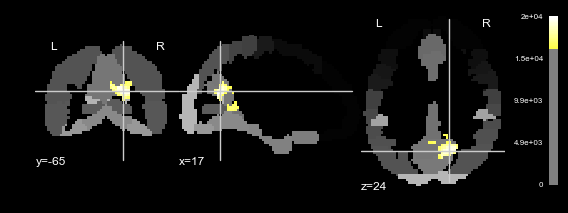

In [45]:
from nilearn import plotting
plotting.plot_stat_map(cj,bg_img=resamp, threshold = 16232.56113)

In [72]:
atlasdf = pd.DataFrame.from_records([{'num':k,'label':dataset.labels[k],'val':v} for k,v in zip(resamp.get_data()[cj.get_data()>16232.56113],cj.get_data()[cj.get_data()>16232.56113])], columns = ['num','label','val'])

In [125]:
atlas_agg = atlasdf.groupby(['label','num'])[['val']].aggregate(['count','mean','median','max']).reset_index()
atlas_agg = atlas_agg.loc[atlas_agg.num !=0,:]

In [126]:
thresh = 16232.56113
res = []
for n in pd.unique(atlas_agg.num):
    r = {}
    r['num'] = n
    atlas_mask = (resamp.get_data()==n)
    cj_mask = cj.get_data()>thresh
    roi_peak = cj.get_data()[atlas_mask & cj_mask].max()
    r['coords'] =  nb.affines.apply_affine(cj.affine,np.array(np.where(atlas_mask.astype(bool) & cj_mask.astype(bool) & (cj.get_data()==roi_peak))).squeeze())
    res.append(r)
res = pd.DataFrame(res)
atlas_agg = atlas_agg.merge(res, on = 'num',how = 'left')
atlas_agg.columns = [             u'num',u'label', u'num_x',
         u'count',   u'mean',  u'median',
          u'max',           u'coords']
atlas_agg = atlas_agg.drop('num_x',axis = 1).sort_values('count', ascending = False)
atlas_agg.to_csv('hamvivcorrel_cj_coords.csv', index = None)

## Get clusters

In [131]:
thresh= 27579.22798
cj_name = cj_name = "ham.tvals_cmask.perm_hamvivcorrel_stlim_SL4_zndist_1000perms_v1.glm_sl.tfce.000.nii.gz"
cj = nb.load(os.path.join(outdir,"stats",cj_name))

In [149]:
atlasdf = pd.DataFrame.from_records([{'num':k,'label':dataset.labels[k],'val':v} for k,v in zip(resamp.get_data()[cj.get_data()>thresh],cj.get_data()[cj.get_data()>thresh])], columns = ['num','label','val'])
atlas_agg = atlasdf.groupby(['label','num'])[['val']].aggregate(['count','mean','median','max']).reset_index()
atlas_agg = atlas_agg.loc[atlas_agg.num !=0,:]
res = []
for n in pd.unique(atlas_agg.num):
    r = {}
    r['num'] = n
    atlas_mask = (resamp.get_data()==n)
    cj_mask = cj.get_data()>thresh
    roi_peak = cj.get_data()[atlas_mask & cj_mask].max()
    r['coords'] =  nb.affines.apply_affine(cj.affine,np.array(np.where(atlas_mask.astype(bool) & cj_mask.astype(bool) & (cj.get_data()==roi_peak))).squeeze().T)
    res.append(r)
res = pd.DataFrame(res)
atlas_agg = atlas_agg.merge(res, on = 'num',how = 'left')
atlas_agg.columns = [             u'num',u'label', u'num_x',
         u'count',   u'mean',  u'median',
          u'max',           u'coords']
atlas_agg = atlas_agg.drop('num_x',axis = 1).sort_values('count', ascending = False)
atlas_agg.to_csv('hamvivcorrel_ham_coords.csv', index = None)

In [150]:
atlas_agg

,num,label,count,mean,median,max,coords
27,62,"Precuneous Cortex, right part",382,34385.001897,33071.980469,48123.324219,"[12.5, -65.5, 23.0]"
17,8,"Middle Frontal Gyrus, right part",193,30099.815070,30100.945312,34687.460938,"[45.0, 32.0, 33.0]"
26,61,"Precuneous Cortex, left part",160,31471.479163,31218.425781,35882.972656,"[-2.5, -63.0, 28.0]"
34,16,"Temporal Pole, right part",91,30264.441277,30437.699219,32481.328125,"[50.0, 12.0, -24.5]"
16,72,"Lingual Gyrus, right part",68,30309.117188,30642.133789,32227.101562,"[12.5, -58.0, 5.5]"
19,24,"Middle Temporal Gyrus, posterior division, rig...",56,30272.090262,30719.492188,31821.724609,"[52.5, -18.0, -17.0]"
3,64,"Cuneal Cortex, right part",54,33206.409433,31846.599609,45559.871094,"[12.5, -68.0, 23.0]"
8,10,"Inferior Frontal Gyrus, pars triangularis, rig...",51,30391.220358,30721.265625,31757.044922,"[55.0, 29.5, 18.0]"
33,78,"Temporal Occipital Fusiform Cortex, right part",49,30347.057478,30410.060547,32620.082031,"[37.5, -50.5, -12.0]"
1,60,"Cingulate Gyrus, posterior division, right part",46,30133.334664,30160.660156,34881.839844,"[12.5, -50.5, 33.0]"
